In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

In [3]:
from pathlib import Path
log_dir = Path('logs/')

In [4]:
from torch.utils.data import Dataset, DataLoader

class ModulatorDataset(Dataset):
    def __init__(self, bit_count):
        super().__init__()
        self.bit_count = bit_count
        
    def __len__(self):
        return 2 ** self.bit_count
    
    def __getitem__(self, idx):
        result = torch.zeros(2 ** self.bit_count)
        result[idx] = 1
        return result

bit_count = 6
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)

In [5]:
class EntropyNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        energy = (x ** 2).sum(axis=1).mean()
        return x / energy.sqrt()

class ModulatorAutoencoder(pl.LightningModule):
    def __init__(self, class_count, encoding_shape):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(class_count, class_count),
            nn.ReLU(),
            nn.Linear(class_count, encoding_shape),
            EntropyNormalization()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_shape, class_count),
            nn.ReLU(),
            nn.Linear(class_count, class_count)
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.symbol_error_rate = torchmetrics.Accuracy()
        
    def forward(self, x):
        encoded = self.encoder(x)
        noise_shape = encoded.shape
        snr = 20
        sigma = np.sqrt(1 / (2 * 10 ** (snr / 10)))
        # current E/noise 10 dB
        noise = torch.normal(torch.zeros(encoded.shape, device=self.device), 
                             torch.ones(encoded.shape, device=self.device) * sigma)
        noised = encoded + noise
        return self.decoder(noised)
    
    def training_step(self, batch, batch_idx):
        decoded = self(batch)
        prediction = decoded.argmax(-1)
        true_classes = batch.argmax(-1)
        loss = self.loss_function(decoded, batch)
        ser = self.symbol_error_rate(prediction, true_classes)
        self.log('ser', ser, on_epoch=True, on_step=False, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer

In [6]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBar
import tqdm


class LitProgressBar(ProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm.tqdm(            
            disable=True,            
        )
        return bar


bar = LitProgressBar()
model = ModulatorAutoencoder(class_count, 2)
logger = CSVLogger(save_dir=log_dir)
device_id = 5
device = torch.device(f'cuda:{device_id}')
trainer = pl.Trainer(max_epochs=10000, logger=logger, gpus=[device_id], callbacks=[bar])
trainer.fit(model, train_dataloaders=dataloader)

/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages/pytorch_lightning/callbacks/progress/progress.py:21: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3060 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3060 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,

Epoch 9999: 100%|█████| 1/1 [00:00<00:00, 11.60it/s, loss=0.246, v_num=138, ser=0.922]


In [1]:
outputs = []
for batch in dataloader:
    cur_outputs = model.to(device).encoder(batch.to(device))
    outputs.append(cur_outputs.cpu().detach().numpy())
points = np.concatenate(outputs)
plt.gca().set_aspect('equal', adjustable='box')
for point in points:
    plt.scatter(x=point[0], y=point[1], c='red')

NameError: name 'dataloader' is not defined

In [7]:
torch.cuda.empty_cache()

In [20]:
predictions = []
labels = []

model.eval()
for _ in range(100000):
    for batch in dataloader:
        encoded = model.to(device).encoder(batch.to(device))
        noise = torch.normal(torch.zeros(encoded.shape, device=device), 
                             torch.ones(encoded.shape, device=device) / 10)
        noised = encoded + noise
        decoded = model.to(device).decoder(noised)
        cur_prediction = decoded.cpu().detach().argmax(-1).numpy()
        cur_labels = batch.argmax(-1).numpy()
        labels.append(cur_labels)
        predictions.append(cur_prediction)

true_labels = np.concatenate(labels)
model_predictions = np.concatenate(predictions)

error_count = (true_labels != model_predictions).sum()
ser = error_count / len(true_labels)
ser

0.003626875

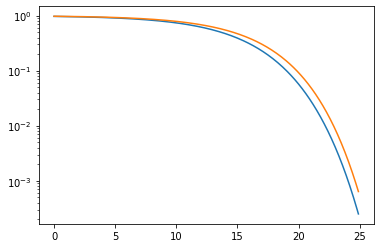

In [4]:
from scipy.special import erfc

def Q(x):
    return erfc(x / np.sqrt(2)) / 2

def p_error(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return 1 - (1 - 2 * Q(np.sqrt(3 / n0 / (q - 1)))) ** 2

def p_stupid(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return np.exp(-3 / 2 / (q - 1) / n0)

snrs = np.arange(0, 25, 0.1)
plt.yscale('log')
# for q in [4, 16, 64]:
for q in [64]:
    ys = [p_error(snr, q) for snr in snrs]
    zs = [p_stupid(snr, q) for snr in snrs]
    plt.plot(snrs, ys)
    plt.plot(snrs, zs)